In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

## Prepare and preprocessing dataset

In [2]:
os.chdir("./drive/MyDrive/Colab Notebooks/")

In [3]:
file_path = "./por_eng_data.txt"

In [4]:
# Converting to ASCII
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [5]:
en_sentence = u"Neural network is quite interesting."
pt_sentence = u"Rede neural é bastante interessante."
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(pt_sentence).encode('utf-8'))

<start> neural network is quite interesting . <end>
b'<start> rede neural e bastante interessante . <end>'


In [6]:
#testting dataset for preprocess each line
dataset_size = len([line.split('\t')[:2] for line in io.open(file_path, encoding='UTF-8').read().strip().split('\n')])
[line.split('\t')[:2] for line in io.open(file_path, encoding='UTF-8').read().strip().split('\n')][:5]

[['Go.', 'Vai.'],
 ['Go.', 'Vá.'],
 ['Hi.', 'Oi.'],
 ['Run!', 'Corre!'],
 ['Run!', 'Corra!']]

In [7]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [PORTUGUESE, SPANISH]
def create_dataset(path, num_examples):
    lines = [line.split('\t')[:2] for line in io.open(file_path, encoding='UTF-8').read().strip().split('\n')]

    #return pair sequence == pt setence and en setense
    word_pairs = [[preprocess_sentence(w) for w in l]  for l in lines[:num_examples]]

    return zip(*word_pairs)

In [8]:
en, pt = create_dataset(file_path, None)
print(en[-1])
print(pt[-1])

<start> a child who is a native speaker usually knows many things about his or her language that a non native speaker who has been studying for years still does not know and perhaps will never know . <end>
<start> uma crianca que e falante nativa geralmente sabe muitas coisas sobre sua lingua que um falante nao nativo que tem estudado ha anos ainda nao sabe e talvez nunca sabera . <end>


In [9]:
len(en), len(pt)

(170305, 170305)

In [10]:
#getting input and target max lenght
leng_pt=[]
leng_en=[]
for i in range(len(en)):
  leng_pt.append(len(pt[i].split()))
  leng_en.append(len(en[i].split()))

input_lenght = np.max(leng_pt)
targ_lenght = np.max(leng_en)

In [11]:
def tokenize(lang, max_len):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=max_len) # fix size value to all the sentense

    return tensor, lang_tokenizer

In [12]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang, 38)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang, 38)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [13]:
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(file_path, 50000)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [14]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.3)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

35000 35000 15000 15000


### Create a tf.data dataset

In [15]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [16]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 38]), TensorShape([64, 38]))

## Building the model 

### Encoder model

In [17]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

#### Testing Encoder model

In [18]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
hidden_state = encoder.initialize_hidden_state()
encoder_out, encoder_hidden = encoder(example_input_batch, hidden_state)
encoder_out.shape, encoder_hidden.shape

(TensorShape([64, 38, 1024]), TensorShape([64, 1024]))

### Attention model

In [19]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

#### Testing Attention model

In [20]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(hidden_state, encoder_out)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 38, 1)


### One step decoder

In [21]:
'''
This class will perform the decoder task.
The main decoder will call this onestep decoder at every time step. This one step decoder in turn class the atention model and return the ouptput 
at time step t.
This output is passed through the final softmax layer with output size =vocab size, and pass this result to the main decoder model

'''
class One_Step_Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_size):
        super(One_Step_Decoder, self).__init__()
        self.batch_sz = batch_size
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                    return_sequences=True,
                                    return_state=True,
                                    recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, enc_output, hidden):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

#### Testing One step decoder

In [22]:
one = One_Step_Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
one_input = tf.expand_dims([1] * BATCH_SIZE, 1)
one_out, one_state, att = one(one_input, encoder_out, encoder_hidden)
one_out.shape, one_state.shape, att.shape

(TensorShape([64, 5668]), TensorShape([64, 1024]), TensorShape([64, 38, 1]))

### Decoder model

In [23]:
#here
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_size):
        super().__init__()
        self.batch_size = vocab_size
        self.onestep = One_Step_Decoder(vocab_size, embedding_dim, dec_units, self.batch_size)
        
    def call(self, input_to_decoder, encoder_output, state):

        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        #Create a tensor array as shown in the reference notebook
        
        #Iterate till the length of the decoder input
            # Call onestepdecoder for each token in decoder_input
            # Store the output in tensorarray
        # Return the tensor array

        all_outputs = tf.TensorArray(tf.float32, input_to_decoder.shape[1], name="output_array") #Store the output in tensorarray
        one_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for step in range(1, input_to_decoder.shape[1]):
            # passing enc_output to the decoder
            output, state, _ = self.onestep(one_input, encoder_output, state)

            all_outputs = all_outputs.write(step, output)

            # using teacher forcing
            dec_input = tf.expand_dims(input_to_decoder[:, step], 1)
        
        all_outputs = tf.transpose(all_outputs.stack(),[1,0,2])
        
        return all_outputs

#### Testing decoder model

In [24]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
dec_out = decoder(example_target_batch, encoder_out, hidden_state)
dec_out.shape #(64, 1) (64, 38, 1024) (64, 1024)

TensorShape([64, 38, 5668])

### Encoder-Decoder

In [25]:
class Encoder_decoder(tf.keras.Model):

    def __init__(self, vocab_inp_size, vocab_tar_size, embedding_dim, output_length, enc_units, dec_units, batch_size):
        super().__init__()
        self.encoder =Encoder(vocab_inp_size, embedding_dim, enc_units, batch_size)
        self.decoder = Decoder(vocab_tar_size, embedding_dim, dec_units, batch_size)
   
    #Coompute the image features using feature extraction model and pass it to the encoder
    # This will give encoder ouput
    # Pass the decoder sequence,encoder_output,initial states to Decoder
    # return the decoder output

    def call(self, data):
        
        state = self.encoder.initialize_hidden_state()

        encoder_output, encoder_state = self.encoder(data, state)

        # print("data shape, state shape, encoder_output, enc_hidden ", data.shape, state.shape, encoder_output.shape, enc_hidden.shape) #(64, 1024) (64, 16, 1024) (64, 1024)

        output= self.decoder(data, encoder_output, encoder_state)

        return output

#### Testing encoder-decoder model

In [26]:
encoder_decoder = Encoder_decoder(vocab_inp_size, vocab_tar_size, embedding_dim, vocab_tar_size, units, units, BATCH_SIZE)

enc_dec_out = encoder_decoder(example_target_batch)
enc_dec_out.shape

TensorShape([64, 38, 5668])

### Final model building

In [27]:
model = Encoder_decoder(vocab_inp_size, 
                        vocab_tar_size, 
                        embedding_dim, 
                        vocab_tar_size,
                        units, 
                        units, 
                        BATCH_SIZE)

#### Optimizer and Loss function

In [28]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

#### Compiling the model

In [29]:
model.compile(optimizer = optimizer,
              loss = loss_function)

#### Callbacks

In [30]:
red_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",
                                            factor = 0.2,
                                            patience=2, 
                                            min_lr=0.0001)

ckpt = tf.keras.callbacks.ModelCheckpoint(filepath = "model2wts/ckpt",
                                        monitor='val_loss', 
                                        verbose=0, 
                                        save_best_only=True,
                                        save_weights_only=False, 
                                        mode='auto')

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              mode='auto',
                                              restore_best_weights = True)

#### Fit the model

In [31]:
# print(input_tensor_train.shape, target_tensor_train.shape)
history = model.fit(x = input_tensor_train[:-56],
          y = target_tensor_train[:-56],
          validation_data = (input_tensor_val[:-24], target_tensor_val[:-24]),
          batch_size = BATCH_SIZE,
          epochs=60,
          callbacks=[red_lr, ckpt, early_stop])

Epoch 1/60
546/546 [==============================] - 243s 390ms/step - loss: 1.0220 - val_loss: 0.7394
Epoch 2/60
546/546 [==============================] - 209s 383ms/step - loss: 0.6871 - val_loss: 0.6072
Epoch 3/60
546/546 [==============================] - 208s 382ms/step - loss: 0.5573 - val_loss: 0.5405
Epoch 4/60
546/546 [==============================] - 208s 381ms/step - loss: 0.4781 - val_loss: 0.4970
Epoch 5/60
546/546 [==============================] - 208s 381ms/step - loss: 0.4202 - val_loss: 0.4736
Epoch 6/60
546/546 [==============================] - 208s 380ms/step - loss: 0.3798 - val_loss: 0.4577
Epoch 7/60
546/546 [==============================] - 207s 380ms/step - loss: 0.3483 - val_loss: 0.4534
Epoch 8/60
546/546 [==============================] - 208s 380ms/step - loss: 0.3298 - val_loss: 0.4486
Epoch 9/60
546/546 [==============================] - 208s 380ms/step - loss: 0.3126 - val_loss: 0.4492


### Evaluating

#### Plotting loss

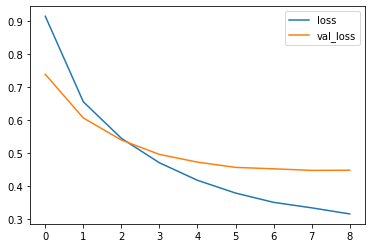

In [32]:
import pandas as pd

history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()

#### Function to plot attention weights

In [33]:
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

#### Function to predict the sentense

In [34]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp)) #getting matrix vector to storage attentions predicted

  sentence = preprocess_sentence(sentence) # preprocess the input setense

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')] # transform all the inputs setense word in tokens 

  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post') # nomalization of the setense to have the same lenght as requirid in input layer network
  inputs = tf.convert_to_tensor(inputs) #converts the inputs in tensors

  result = ''

  hidden = [tf.zeros((1, units))] #Creating the hidden inicial state to pass to the encoder layer
  enc_out, enc_hidden = model.layers[0](inputs, hidden) # predicting with encoder model

  one_hidden = enc_hidden #encoder hidden state autput wil be passed to one step decoder
  one_input = tf.expand_dims([targ_lang.word_index['<start>']], 0) #first input will be the start token <start>

  for t in range(max_length_targ):
    predictions, one_hidden, attention_weights = model.layers[1].onestep(one_input,
                                                                         enc_out,
                                                                         one_hidden) #call the one step layer to get predicton on the encoder output and hidden state
    
    print(predictions.shape)
    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy() # getting the max value in predict correspondent to the most scored word

    result += targ_lang.index_word[predicted_id] + ' ' #concatenating eat word predicted

    if targ_lang.index_word[predicted_id] == '<end>': #checking if the sentense ends
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    one_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

#### Predicting

In [35]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

(1, 5668)
(1, 5668)
(1, 5668)
(1, 5668)
(1, 5668)
(1, 5668)
Input: <start> tenha um bom dia <end>
Predicted translation: have a good day . <end> 


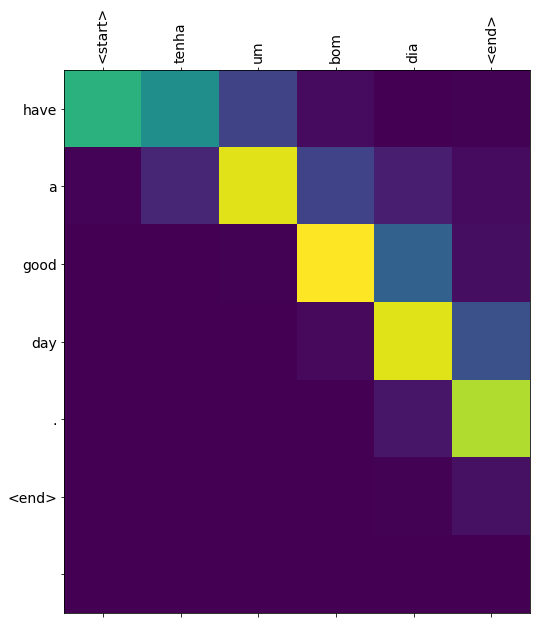

In [36]:
translate('Tenha um bom dia')